# Problem Set 4
### Alex Weinberg, Isaac Norwich, Jose Quintero
### May 5, 2022

---
# Problem 2
The goal of this problem is to explore how to approach event study designs - why two-way fixed- effect (TWFE) regressions will not get you what you want and how to do something else instead. Callaway and Sant’Anna (2020) is highly recommended reading. You may also want to look at Goodman-Bacon (2020) and/or Sun and Abraham (2020).

Note: You may notice that there exists an R package “did”, created by the authors, to imple- ment Callaway & Sant’Anna (2020). The goal of this pset is NOT for you to use this package. You will want to use the package for any real-world implementation, but here I am asking you only to estimate mean effects, never standard errors, and so you should be able to do everything by building your own code using the equations from class & consulting with the Callaway & Sant’Anna and Goodman-Bacon papers if necessary.
In this problem, you will simulate your own data. Because of this, you will know the underlying data generating process and what the “true” value of the parameters are and will be able to see how far astray TWFE can take you.
We consider a setting in which all 50 states in the U.S. implement a policy change (all units are eventually treated), but at different times. States are sorted into “treatment groups” depending on when they enacted the policy g ∈ {1986,1992,1998,2004}. Assume throughout this question that treatment is unanticipated (if you are referencing the notation of the Callaway and Sant’Anna paper, δ = 0).
Steps for data-generation:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf     # for the ols and robust ols model

# Pandas display options
pd.options.display.float_format = '{:.2f}'.format

# Adjust default figure size
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("notebook")

# Figure style 
sns.set_style("whitegrid")

In [2]:
# PARAMETERS
T = 30 # number of periods
N = 1000 # number of units
S = 50 # number of states
g_list = [1986, 1992, 1998, 2004] # treatment groups

base_year = 1980
final_year = base_year + T

np.random.seed(421) # set seed to my birthday

In [3]:
# NUMERICAL PARAMETERS
M = 100 # num. of monte carlo simulations.

In [4]:
# Simulate Data
i = np.arange(0,N) # vector of units
s = np.random.choice(S, N) # uniform draw from 0:S 
g = np.random.choice(g_list,S) # randomly assign states to g

In [5]:
# Create state map from state to treatment
df_treatment = pd.DataFrame({'state':np.arange(S), 'treatment':g})

print('Treatment shares')
print(df_treatment['treatment'].value_counts(normalize=True))
print('--')
print('State size')
print(df_treatment['state'].value_counts(normalize=True))



Treatment shares
1992   0.30
1986   0.26
1998   0.24
2004   0.20
Name: treatment, dtype: float64
--
State size
0    0.02
37   0.02
27   0.02
28   0.02
29   0.02
30   0.02
31   0.02
32   0.02
33   0.02
34   0.02
35   0.02
36   0.02
38   0.02
1    0.02
39   0.02
40   0.02
41   0.02
42   0.02
43   0.02
44   0.02
45   0.02
46   0.02
47   0.02
48   0.02
26   0.02
25   0.02
24   0.02
23   0.02
2    0.02
3    0.02
4    0.02
5    0.02
6    0.02
7    0.02
8    0.02
9    0.02
10   0.02
11   0.02
12   0.02
13   0.02
14   0.02
15   0.02
16   0.02
17   0.02
18   0.02
19   0.02
20   0.02
21   0.02
22   0.02
49   0.02
Name: state, dtype: float64


In [6]:
# Map units to states, treatment
df_unit = pd.DataFrame({'unit':i, 'state':s}) # initialize data, assign states
df_unit = pd.merge(df_unit, df_treatment, on='state',how='outer',validate =  'm:1', indicator=True) # merge in treatment

assert np.all(df_unit['_merge'] == 'both') # assert merge worked

In [7]:
df_unit = df_unit.sort_values('unit').reset_index(drop=True)
df_unit.head()

,unit,state,treatment,_merge
0,0,23,1992,both
1,1,44,1998,both
2,2,19,2004,both
3,3,17,1998,both
4,4,15,1992,both


For each unit, simulate outcome data from 1980 to 2010 drawn from the following Data Generating Process:

$$
Y_{i t}=\underbrace{(2010-g)}_{\text {group intercept }}+\alpha_{i}+\alpha_{t}+\tau_{i t}+\epsilon_{i t}
$$

where
- $\alpha_{i}$ are unit fixed effects drawn randomly from $\sim N\left(\frac{\text { state }}{5}, 1\right)$
- $\alpha_{t}$ are time fixed effects generated as
$$
\alpha_{t}=0.1 *(t-g)+\epsilon^{t i m e F E}
$$
with $\epsilon^{\text {timeFE }} \sim N(0,1)$
- $\epsilon_{i t} \sim N\left(0,\left(\frac{1}{2}\right)^{2}\right)$ is an idiosyncratic error term
- $\tau_{i, t}$ are the unit-specific treatment effects at time t generated as
$$
\tau_{i t}=\underbrace{1}_{\text {instantaneous treatment effect }} \times(t-g+1) \times 1\{t \geq g\}
$$

In [8]:
class MCsim:
    '''This class is a single simulation of the DGP'''
    def __init__(self, df_unit):
        # ======================== #
        # INDIVIDUAL FIXED EFFECTS
        # ======================== #
        df_unit['alpha_i'] = np.random.normal(df_unit.state / 5, 1) # individual FE

        # ======================== #
        # TIME FIXED EFFECTS
        # ======================== #

        # generate time dimension
        df_it = pd.concat([df_unit]*T, ignore_index=True) # duplicate each unit T times.
        df_it['year'] = base_year + df_it.groupby('unit').cumcount() # create t=1,..,T for each unit

        # time fixed effects
        eps_time_FE = np.random.normal(0,1,size=N*T)
        df_it['alpha_t'] = 0.1 * (df_it.year - df_it.treatment) + eps_time_FE

        # ======================== #
        # IDIOSYNCRATIC ERROR
        # ======================== #
        eps_it = np.random.normal(0,0.5,size=N*T)

        # ======================== #
        # TREATMENT EFFECT
        # ======================== #
        df_it['tau_it'] = (df_it.year - df_it.treatment + 1) * (df_it.year >= df_it.treatment)

        # ======================== #
        # TREATMENT EFFECT
        # ======================== #
        df = df_it
        df['y_it'] = (final_year - df.treatment) + df.alpha_i + df.alpha_t + df.tau_it + eps_it
        
        df.set_index(['unit', 'year'], inplace=True)
        self.df = df
        return

#     df.head()

In [9]:
df = MCsim(df_unit).df
df.head()

,,state,treatment,_merge,alpha_i,alpha_t,tau_it,y_it
unit,year,,,,,,,
0,1980,23,1992,both,2.97,1.55,0,22.43
1,1980,44,1998,both,8.48,-2.65,0,17.47
2,1980,19,2004,both,2.90,-1.60,0,7.95
3,1980,17,1998,both,4.53,-1.97,0,14.00
4,1980,15,1992,both,3.30,-1.57,0,20.05


At this point, I have successfully generated the simulated data. 

---

### Part A
Examine the Data Generating Process. Which part of the equation is the ATT? Simulate out the data once (later you will be asked to repeat many times - set a seed!) and graph the ATT for each group in calendar time (i.e. put t on the x-axis).

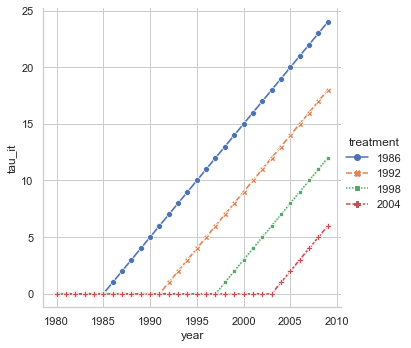

In [10]:
# the ATT for each group is given by \tau_it


att = sns.relplot(x="year", y="tau_it", hue='treatment', style='treatment', kind='line',
            markers=True, legend = 'auto', palette="deep", data=df);



---
## Part B
Now plot the ATT in “event time” (i.e. t − g). Are treatment effects homogeneous in this setting? Describe the evolution of treatment effects after treatment time.


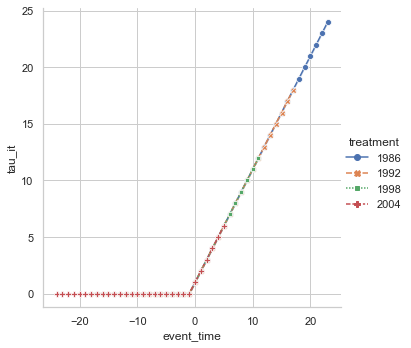

In [11]:
df['event_time'] = df.index.get_level_values("year") - df.treatment

att_g = sns.relplot(x="event_time", y="tau_it", hue='treatment', style='treatment', kind='line',
            markers=True, legend = 'auto', palette="deep", data=df);


--- 
## Part C

Are you willing to make a parallel trends assumption? What are you willing to assume would have evolved in parallel, compared to what? Why (or why not) do you find this assumption reasonable?

**Solution** Yes I am willing to make the parallel trends assumption here. Here we happen to know explicitly what the cohort specific time trends are. The time fixed effect is given by

$$
\alpha_t = 0.1 (t-g) + \epsilon_{TimeFE}
$$

So here, the trends are parallel and because we know the trend ($0.1$) is identical for each cohort we are safe to assume that in the absense of treatment, the cohorts would have been on the same trend.

---
## Part D

Now we will run TWFE regression using "event study" dummy variables $D_{i t}^{k}=1\left\{t-G_{i}=k\right\}$ which take value one if unit $i$ is $k$ periods away from initial treatment at time $t$ and zero otherwise. Your regression should look like this:
$$
Y_{i t}=\alpha_{i}+\alpha_{t}+\gamma_{k}^{-5} D_{i, t}^{<-5}+\sum_{k=-5}^{-2} \gamma_{k}^{l e a d} D_{i t}^{k}+\sum_{k=0}^{5} \gamma_{k}^{l a g} D_{i t}^{k}+\gamma_{k}^{5+} D_{i, t}^{>5}+\epsilon_{i t}
$$
where $D_{i, t}^{<-5}=1\left\{t-G_{i}<-5\right\}$ and $D_{i, t}^{>5}=1\left\{t-G_{i}>5\right\}$. Note that we are "leaving out" the dummy for event time $k=-1$

Historically (until very recently) people have interpreted $\gamma_{k}^{l a g}$ as a measure of the average treatment effect of being exposed to treatment for $k$ periods, and estimates of $\gamma_{k}^{\text {lead }}$ as measures of pre-trends. As we will see, this is not a correct interpretation.

We will perform a Monte Carlo exercise where we generate data according to the DGP de- scribed above and estimate the TWFE regression. Repeat this 100 times, saving the values of the gammas each time.

In [12]:
# Here I simulate M=100 monte carlo simulations of the above DGP. 
# Then I run the above regression and store the coefficient in a vector
# Finally, I take the mean of that vector and report it

gamma_n6 = np.zeros(M)
gamma_n5 = np.zeros(M)
gamma_n4 = np.zeros(M)
gamma_n3 = np.zeros(M)
gamma_n2 = np.zeros(M)
gamma_0 = np.zeros(M)
gamma_1 = np.zeros(M)
gamma_2 = np.zeros(M)
gamma_3 = np.zeros(M)
gamma_4 = np.zeros(M)
gamma_5 = np.zeros(M)
gamma_6 = np.zeros(M)


# RUN SIMULATION
print('\n--\n')
for mm in range(M):
    
#     print('\nSimulation number ', mm)
        
    # simulate the data
    df_mm = MCsim(df_unit).df 
    
    # Set event time above and below 5,-5 respectively to the 6, -6
    df_mm['event_time'] = df_mm.index.get_level_values("year") - df_mm.treatment
    df_mm.loc[df_mm['event_time']< -5, 'event_time'] = -6
    df_mm.loc[df_mm['event_time']> 5, 'event_time']  = 6   
    
    # need unit and time vars
    df_mm.reset_index(inplace=True)
    
    # python omits the first one
    df_mm.loc[df_mm['event_time']== -1, 'event_time'] = -1e5
    
    
    # Run regression
    formula = 'y_it ~ 1 + C(year) + C(unit) + C(event_time)'
    results = smf.ols(formula=formula, data=df_mm).fit()
    
    # Store coefficients
    gamma_0[mm]  = results.params['C(event_time)[T.0]']
    gamma_n2[mm] = results.params['C(event_time)[T.-2]']
    gamma_n3[mm] = results.params['C(event_time)[T.-3]']
    gamma_n4[mm] = results.params['C(event_time)[T.-4]']
    gamma_n5[mm] = results.params['C(event_time)[T.-5]']
    gamma_n6[mm] = results.params['C(event_time)[T.-6]']
    
    gamma_1[mm] = results.params['C(event_time)[T.1]']
    gamma_2[mm] = results.params['C(event_time)[T.2]']
    gamma_3[mm] = results.params['C(event_time)[T.3]']
    gamma_4[mm] = results.params['C(event_time)[T.4]']
    gamma_5[mm] = results.params['C(event_time)[T.5]']
    gamma_6[mm] = results.params['C(event_time)[T.6]']
#     results.summary()


# STORE RESULTS IN DATAFRAME
df_montecarlo = pd.DataFrame({'gamma-6': gamma_n6,
                              'gamma-5': gamma_n5,
                              'gamma-4': gamma_n4,
                              'gamma-3': gamma_n3,
                              'gamma-2': gamma_n2,
                              'gamma0': gamma_0,
                              'gamma6': gamma_6,
                              'gamma5': gamma_5,
                              'gamma4': gamma_4,
                              'gamma3': gamma_3,
                              'gamma2': gamma_2,
                              'gamma1': gamma_1})


--



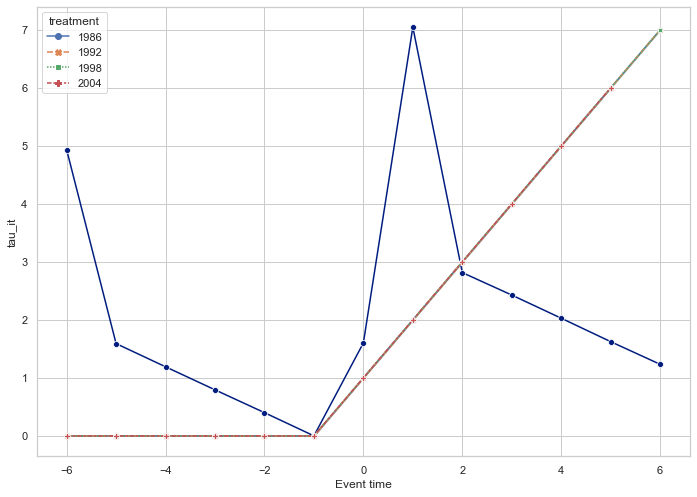

In [13]:
index = [-6, -5, -4, -3, -2, 0, 1, 2, 3,4 ,5 ,6]
df_plot = pd.DataFrame({'Coefficient':df_montecarlo.mean().values}, index=index) # coefficients

aux = pd.DataFrame({'Coefficient':[0]}, index=[-1])
aux.iloc[-1] = 0

df_plot = pd.concat([df_plot, aux]) # append a zero at negative -1
df_plot.index.name = 'Event time'


# PLOT
fig, ax = plt.subplots()

twfe = sns.lineplot(markers=True, legend=False, palette='dark',data=df_plot, ax=ax);
att = sns.lineplot(x="event_time", y="tau_it", hue='treatment', style='treatment',
            markers=True, legend = 'auto', palette="deep", ax = ax, data=df[df.event_time.between(-6,6)]);




See above figure for the plot of mean gamma coefficients. 

The estimates are not the treatment effects because they are the weighted average of all the 2x2 comparisons. OLS is variation hungry and make comparisions we don't like. There may be negative weights (Goodman Bacon 2020) and estmates may be affected by the size of each group Callaway and Santana (2020).  

### Part E
People commonly use the γlead as measures of “pre-trends” to visualize the parallel trends as- k
sumption. Would you find pre-trends if you so used the γs here? Are there truly pre-trends? (see Sun & Abraham for elaboration on this issue).


**Solution:** We cannot use the gammas here to find the pre-trends. The problem is that they are affected by both the actual pretrends and treatment effect heterogeniety. 

### Part F
Now we will discard the TWFE regression and instead follow the procedure recommended by Callaway \& Sant'Anna (2020). Their building block parameter of interest is a treatment group-specific, time-specific average treatment effect:
$$
A T T(g, t)=E\left[Y_{i g t}(1)-Y_{i g t}(0) \mid G_{i}=g\right]
$$
f) For what set of g and t can you identify $A T T(g, t)$ ? Write the estimand. Elaborate on what assumptions you need to make and what comparison group you will be using. How do these comparisons differ from the comparisons used in the TWFE regression?

**Solution:** Following Callaway and Santana (2020), I can use their theorem and estimator to identify treatment effects. 


In our setup there does not exist a never-treated group. So I can only identify ATT(g,t) for time periods before the 2004 group is treated. 

Following CS 2020, I look at 

$$
ATT(g,t) = E[Y_t - Y_{g-1} | G=g] - E[Y_t - Y_{g-1} | D=0,G\neq g]
$$

The first difference is change for the treated subtracting change for the average of the controls.

*Assumptions*

1. No takebacks - once treated, you do not become untreated. 
2. Everything is IID
3. No anticipation 
5. Parallel trends 
6. Overlap

These assumptions clearly hold due to the DGP so by CS (2020) their estimator is identified.

### Part G
Estimate the ATT(g,t)s you said are identified in (f). Plot the estimates for each group in calendar time.


In [58]:
pre_period = df.loc[df.event_time == -1, 'y_it'] # pre-period
pre_period.name = 'preY'
pd.merge(df, pre_period, on='unit')


,state,treatment,_merge,alpha_i,alpha_t,tau_it,y_it,event_time,dy,tau2_it,preY
unit,,,,,,,,,,,
0,23,1992,both,2.97,1.55,0,22.43,-12,NaN,15.76,21.10
0,23,1992,both,2.97,-1.85,0,20.26,-11,-2.18,-2.94,21.10
0,23,1992,both,2.97,-0.73,0,21.05,-10,0.79,2.45,21.10
0,23,1992,both,2.97,-1.20,0,21.37,-9,0.32,-7.19,21.10
0,23,1992,both,2.97,-1.70,0,19.11,-8,-2.26,7.35,21.10
...,...,...,...,...,...,...,...,...,...,...,...
999,47,1986,both,9.31,2.55,20,55.57,19,3.04,10.14,31.84
999,47,1986,both,9.31,3.33,21,58.80,20,3.23,20.60,31.84
999,47,1986,both,9.31,0.59,22,55.44,21,-3.36,20.96,31.84


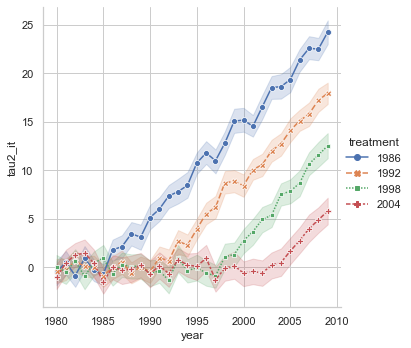

In [57]:
# I feel like this is too noisey? 
# Come back and redo the CS ATT estimates

### Part H

I aggregate the ATTs together such as 3.8 equation in CS (2020).

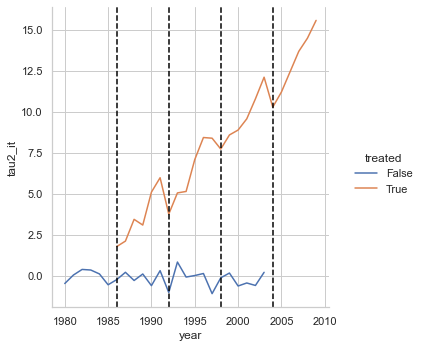

In [86]:
att_cs2020 = sns.relplot(x="year", y="tau2_it", markers=True, hue = 'treated', kind='line', palette="deep", data=df2)

for gg in g_list:
    att_cs2020.refline(x=gg, color = "black")

Apologies, due to time constraints I am not able to fix the graph. 

Essentially the ATT aggregate is the blue line until the first group is treated and then it becomes the orange line. Notice how the ATT dips every time a new group is treated. This is because treatment effects grow over time so adding a newly treated brings down the average. 